In [34]:
from rd3d import set_workspace

set_workspace()
import torch
import numpy as np
import accelerate

from rd3d.datasets import build_dataloader
from rd3d.core import Config
from rd3d.models import build_detector
from rd3d.core.ckpt import load_from_file
from matplotlib import pyplot as plt

# cfg_file = "configs/voxformer/voxformer_4x2_80e_kitti_3cls.py"
# ckpt_file = '/home/nrsl/workspace/temp/voxformer/output/kitti_3cls/voxformer_4x2_80e_kitti_3cls/vfe_seg/train/ckpt/checkpoint_epoch_80.pth'

# cfg_file = "configs/voxformer/voxformer_4x2_80e_kitti_3cls.py"
# ckpt_file = '/home/nrsl/workspace/temp/voxformer/output/kitti_3cls/voxformer_4x2_80e_kitti_3cls/seg/train/ckpt/checkpoint_epoch_80.pth'

cfg_file = "configs/voxformer/voxformer_vfe_seg_ms4.py"
ckpt_file = 'output/kitti_3cls/voxformer_4x2_80e_kitti_3cls/vfe_seg_ms4/train/ckpt/checkpoint_epoch_80.pth'


acc = accelerate.Accelerator()
cfg = Config.fromfile_py(cfg_file)

dataloader = build_dataloader(cfg.DATASET, cfg.RUN, training=False)
model = build_detector(cfg.MODEL, dataset=dataloader.dataset).cuda()
load_from_file(ckpt_file, model)
model = model.eval()


[2023-12-20 23:19:29,361 cfg INFO] import module at root: /home/nrsl/workspace/temp/voxformer
[2023-12-20 23:19:29,362 cfg INFO] import module as config: configs.voxformer.voxformer_vfe_seg_ms4
[2023-12-20 23:19:29,368 dataset INFO] Loading KITTI dataset
[2023-12-20 23:19:29,543 dataset INFO] Total samples for KITTI dataset: 3769
[2023-12-20 23:19:29,651 ckpt INFO] load checkpoint output/kitti_3cls/voxformer_4x2_80e_kitti_3cls/vfe_seg_ms4/train/ckpt/checkpoint_epoch_80.pth to cuda:0
[2023-12-20 23:19:29,651 ckpt INFO] checkpoint trained from version: 0.5.2+0000000
[2023-12-20 23:19:29,659 ckpt INFO] loaded params for model (123/123)


In [35]:
from tqdm import tqdm

seg_model = lambda x: model.dense_head(model.backbone_3d(model.vfe(x)))
loss_list = []
with torch.no_grad():
    for batch_dict in tqdm(iterable=iter(dataloader)):
        dataloader.dataset.load_data_to_gpu(batch_dict)
        batch_dict = seg_model(batch_dict)
        model.dense_head.train_dict.update(numbs=batch_dict['voxel_numbers'],
                                           coors=batch_dict['point_coords'],
                                           logits=batch_dict['cls_logits'])
        model.dense_head.assign_targets(batch_dict)
        loss, _ = model.dense_head.get_loss({})
        loss_list.append(loss.item())

100%|██████████| 472/472 [01:16<00:00,  6.19it/s]


2.0547642873726404 0.7198597453668787


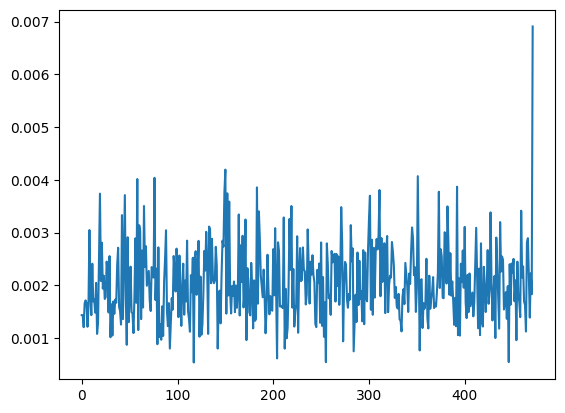

In [36]:
# vfe_res_seg: 2.2355085185786185 0.7590413656001402
# vfe_seg: 2.0912294999954795 0.723367053989105
# seg: 2.2270977646319623 0.7658504044920723
# vfe_seg_ms4 2.0547642873726404 0.7198597453668787
losses = np.array(loss_list)
print(losses.mean() * 1000, losses.std() * 1000)
plt.plot(losses)